In [1]:
%%time
# Standard Library Imports
import os
import shutil

# Local Imports

# Third Party Imports
import ants
import numpy as np
import tifffile

from clearex.registration.linear import import_affine_transform, transform_image, export_tiff
import clearex.file_operations.tools as tools
from clearex.plot.images import mips



CPU times: user 14.9 s, sys: 2.01 s, total: 16.9 s
Wall time: 38.8 s


In [2]:
%%time
channel = 1
path_to_fixed_data = f'/archive/bioinformatics/Danuser_lab/Dean/Seweryn/s2/Sytox_ppm1/250320/new_Cell4/1_CH0{channel}_000000.tif'
path_to_moving_data = f'/archive/bioinformatics/Danuser_lab/Dean/Seweryn/s2/restained/Cell1/1_CH0{channel}_000000.tif'
path_to_save_to = "/archive/bioinformatics/Danuser_lab/Dean/dean/2025-05-28-registration"
path_to_affine_transform = os.path.join(path_to_save_to, "AffineTransform.mat")

CPU times: user 0 ns, sys: 28 μs, total: 28 μs
Wall time: 37.7 μs


In [3]:
%%time
print(f"Loading fixed image: {path_to_fixed_data}")
fixed_roi = tifffile.imread(path_to_fixed_data)

print(f"Loading moving image: {path_to_moving_data}")
moving_roi = tifffile.imread(path_to_moving_data)
print("Image shape:", moving_roi.shape)

Loading fixed image: /archive/bioinformatics/Danuser_lab/Dean/Seweryn/s2/Sytox_ppm1/250320/new_Cell4/1_CH01_000000.tif
Loading moving image: /archive/bioinformatics/Danuser_lab/Dean/Seweryn/s2/restained/Cell1/1_CH01_000000.tif
Image shape: (1106, 800, 2048)
CPU times: user 4.23 s, sys: 11.5 s, total: 15.7 s
Wall time: 2min 8s


In [4]:
%%time
print(f"Importing affine transform from: {path_to_affine_transform}")
transform = import_affine_transform(path_to_affine_transform)

Importing affine transform from: /archive/bioinformatics/Danuser_lab/Dean/dean/2025-05-28-registration/AffineTransform.mat
CPU times: user 15.2 ms, sys: 10.5 ms, total: 25.7 ms
Wall time: 1.07 s


In [5]:
%%time
print("Applying transform to moving image...")
transformed_image = transform_image(moving_roi, fixed_roi, transform)

Applying transform to moving image...
CPU times: user 5min 58s, sys: 1min 26s, total: 7min 24s
Wall time: 4min 5s


In [10]:
%%time
print("Identifying smallest ROI that encapsulates the data.")
fixed_roi, transformed_image = tools.crop_overlapping_datasets(
    fixed_roi,
    transformed_image,
    robust=True,
    lower_pct = 3,
    upper_pct = 97,
)
print(f"Cropped image shape: {fixed_roi.shape}")
# Original data shape: 1106, 800, 2048
# Non-robust data shape: 1058, 544, 1929
# Robust data shape with 5 and 95% bounds: 852, 136, 1353
# Robust data shape with 3 and 97% bounds: 925, 163, 1525

Identifying smallest ROI that encapsulates the data.
Cropping data to: (slice(62, 987, None), slice(354, 517, None), slice(404, 1929, None))
Cropped image shape: (925, 163, 1525)
CPU times: user 14.4 s, sys: 12.5 s, total: 26.9 s
Wall time: 27 s


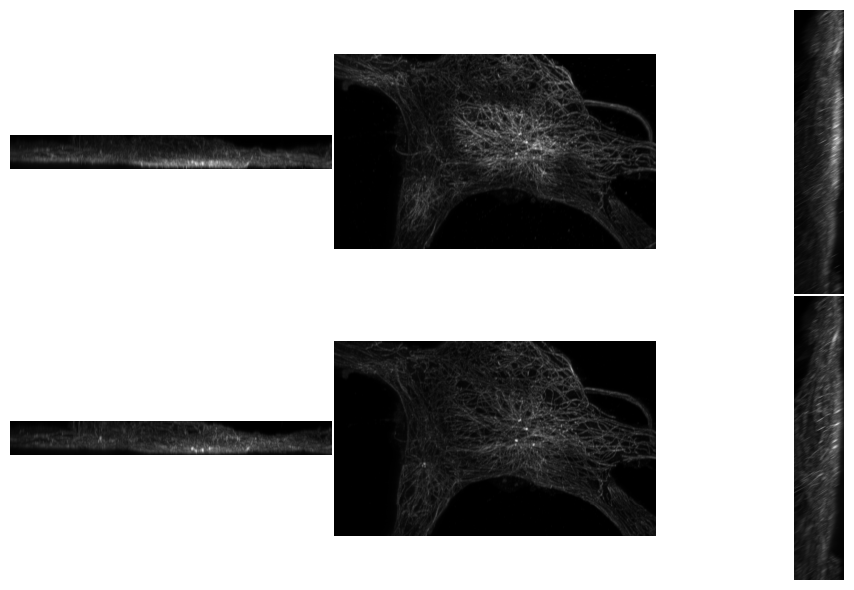

In [11]:
mips(fixed_roi, transformed_image)

In [12]:
%%time
print("Exporting cropped reference and moving images.")
export_tiff(
    image=transformed_image,
    data_path=os.path.join(path_to_save_to, "cropped_moving.tif"))

export_tiff(
    image=fixed_roi,
    data_path=os.path.join(path_to_save_to, "cropped_fixed.tif"))

Exporting cropped reference and moving images.
CPU times: user 2.38 s, sys: 1.02 s, total: 3.4 s
Wall time: 5.03 s


In [13]:
%%time

registration_type = "SyNOnly"
print(f"Performing nonlinear {registration_type}-type registration.")

# Convert images to ANTsImage if they are numpy arrays.
if isinstance(fixed_roi, np.ndarray):
    fixed_roi = ants.from_numpy(fixed_roi)
if isinstance(transformed_image, np.ndarray):
    transformed_image = ants.from_numpy(transformed_image)

kwargs = {
    "fixed": fixed_roi,
    "moving": transformed_image,
    "type_of_transform": registration_type,
    "flow_sigma": 3.0,
    "total_sigma": 0.5,
    "shrink_factors": [2, 1], # 4, 2, 1
    "smoothing_sigmas": [1, 0], #2, 1, 0
    "metric": "CC", # MeanSquares, CC, Mattes, NormalizedMutualInformation
    "singleprecision": False,
    "aff_random_sampling_rate": 1.0,
    "verbose": True,
    "reg_iterations": (100, 70, 50), #vector of iterations for syn, 100, 70, 50.
    "initial_transform": 'Identity'
    }

# Register the images. This will return a dictionary with the results.
registered = ants.registration(**kwargs)

Performing nonlinear SyNOnly-type registration.
antsRegistration -d 3 -r Identity -m mattes[0x2aaab46fafc8,0x2aae7dd6fca8,1,32] -t SyN[0.200000,3.000000,0.500000] -c [10x10,1e-7,8] -s 1x0 -f 2x1 -u 1 -z 1 -o [/tmp/tmpycdrvqlz,0x2aae7dd6fde8,0x2aae7dd6fe08] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Identity (type = MatrixOffsetTransformBase)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
  number of levels = 2
  fixed image: 0x2aaab46fafc8
  moving image: 0x2aae7dd6fca8
Dimension = 3
Number of stages = 1
Use histogram matching = true
Winsorize image intensities = false
  Lower quantile = 0
  Upper quantile = 1


Stage 1 State
   Image metric = MattesMI
     Fixed image = Image (0x557dcd0)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 2
  Modified Time: 1190
  Debug: Off
  Object Name: 

In [14]:
%%time
print("Reading the transformation from disk.")
registered

Reading the transformation from disk.
CPU times: user 728 μs, sys: 0 ns, total: 728 μs
Wall time: 647 μs


{'warpedmovout': ANTsImage (RAI)
 	 Pixel Type : unsigned int (uint32)
 	 Components : 1
 	 Dimensions : (925, 163, 1525)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'warpedfixout': ANTsImage (RAI)
 	 Pixel Type : unsigned int (uint32)
 	 Components : 1
 	 Dimensions : (925, 163, 1525)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'fwdtransforms': ['/tmp/tmpycdrvqlz1Warp.nii.gz',
  '/tmp/tmpycdrvqlz0GenericAffine.mat'],
 'invtransforms': ['/tmp/tmpycdrvqlz0GenericAffine.mat',
  '/tmp/tmpycdrvqlz1InverseWarp.nii.gz']}

In [19]:
%%time
print("Histogram matching the warped data to the original data.")
# Histogram match to original data.
warped_image = ants.histogram_match_image(
    source_image=registered['warpedmovout'],
    reference_image=transformed_image
    # number_of_match_points=...
    # use_threshold_at_mean_intensity=...
)


Histogram matching the warped data to the original data.
CPU times: user 34.1 s, sys: 3.82 s, total: 37.9 s
Wall time: 24.1 s


In [20]:
print(f"Exporting non_linear_registered.tif to {path_to_save_to}")
export_tiff(
    image=warped_image,
    data_path=os.path.join(path_to_save_to, "non_linear_registered.tif"))


Exporting non_linear_registered.tif to /archive/bioinformatics/Danuser_lab/Dean/dean/2025-05-28-registration


In [ ]:
print("Exporting affine transform and nonlinear warping transform. ")
for filepath in registered['fwdtransforms']:
    filename = os.path.basename(filepath)
    shutil.copy2(filepath, os.path.join(path_to_save_to, filename))

In [21]:
print("Calculating average displacement amplitude. ")
warp = ants.image_read(os.path.join(path_to_save_to, "tmpycdrvqlz1Warp.nii.gz")).numpy()
mag = np.linalg.norm(warp, axis=-1)  # magnitude at each voxel
avg_disp = mag.mean()
max_disp = mag.max()
print(f"Average displacement: {avg_disp:.2f} mm, Max displacement: {max_disp:.2f} mm")

Calculating average displacement amplitude. 
Average displacement: 0.14 mm, Max displacement: 5.09 mm


Plotting non-linear warping.


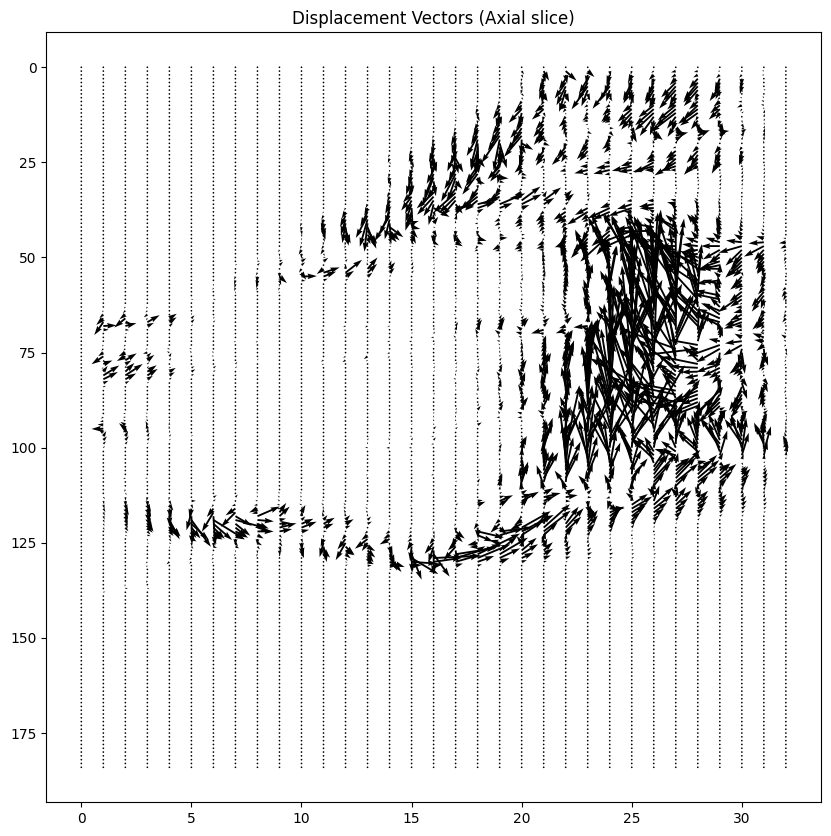

In [25]:
print("Plotting non-linear warping.")
import matplotlib.pyplot as plt

z = warp.shape[2] // 2  # middle axial slice
u = warp[:, :, z, 0]  # x-component
v = warp[:, :, z, 1]  # y-component

plt.figure(figsize=(10, 10))
plt.quiver(u[::5, ::5], v[::5, ::5])  # subsample for readability
plt.title("Displacement Vectors (Axial slice)")
plt.gca().invert_yaxis()
plt.show()